# Домашнее задание 1

Для решения задачи регрессии  - предсказания Customer Livetime Value (CLV или LTV)  по датасету https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data будем использовать алгоритмы бустинга.

Задачу будем решать в несколько шагов:
<ul>

<li> Шаг 1  - предобработка данных. Посмотрим на данные, на корреляцию с таргетной переменной, переведем категориальные переменные в числовые
    
<li> Шаг 2 - сравнение работы алгоритмов бустинга без настройки гиперпараметров
    
<li> Шаг 3 - настройка гиперпараметров с помощью GridSearch и проверка моделей с измененными гиперпараметрами на тестовой выборке.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Шаг 1. Загрузим данные и проведем предварительную обработку (EDA)

In [2]:
df = pd.read_csv('LVC.csv')
df.head(5)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

Удалим колонки с номером клиента и датой окончания работы с клиентом, так как номер не даст никакой информации для регрессии, а дата дублирует таргет, так как показывает день окончания контракта, а Customer Lifetime Value общий срок контракта (скорее всего в часах).

Проверим наличие пустых значений. Урра, их нет!

In [4]:
df = df.drop(['Customer', 'Effective To Date'], axis = 1)
columns_with_empty = [x for x in df.columns if df[x].isnull().sum() > 0]
columns_with_empty

[]

Разделим все признаки на категориальные и числовые. Построим графики, чтобы визуализировать влияние каждого из них на таргет - Customer Lifetime Value

In [5]:
numeric_features = [x for x in df.columns if df[x].dtype != 'object']
categorical_features = [x for x in df.columns if df[x].dtype == 'object']

<AxesSubplot:xlabel='Customer Lifetime Value', ylabel='Count'>

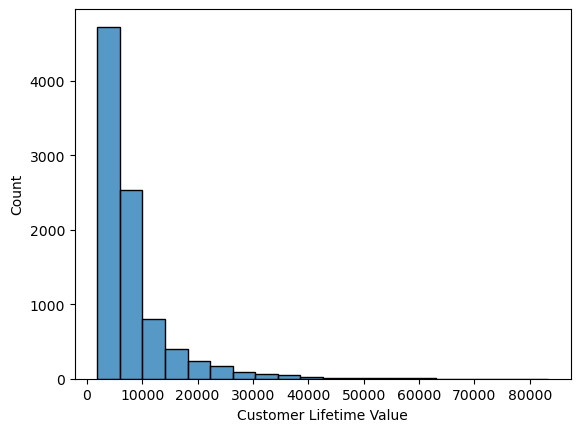

In [6]:
# Customer Lifetime Value - это таргетная метрика, посмотрим ее распределение
sns.histplot(df['Customer Lifetime Value'], bins = 20)

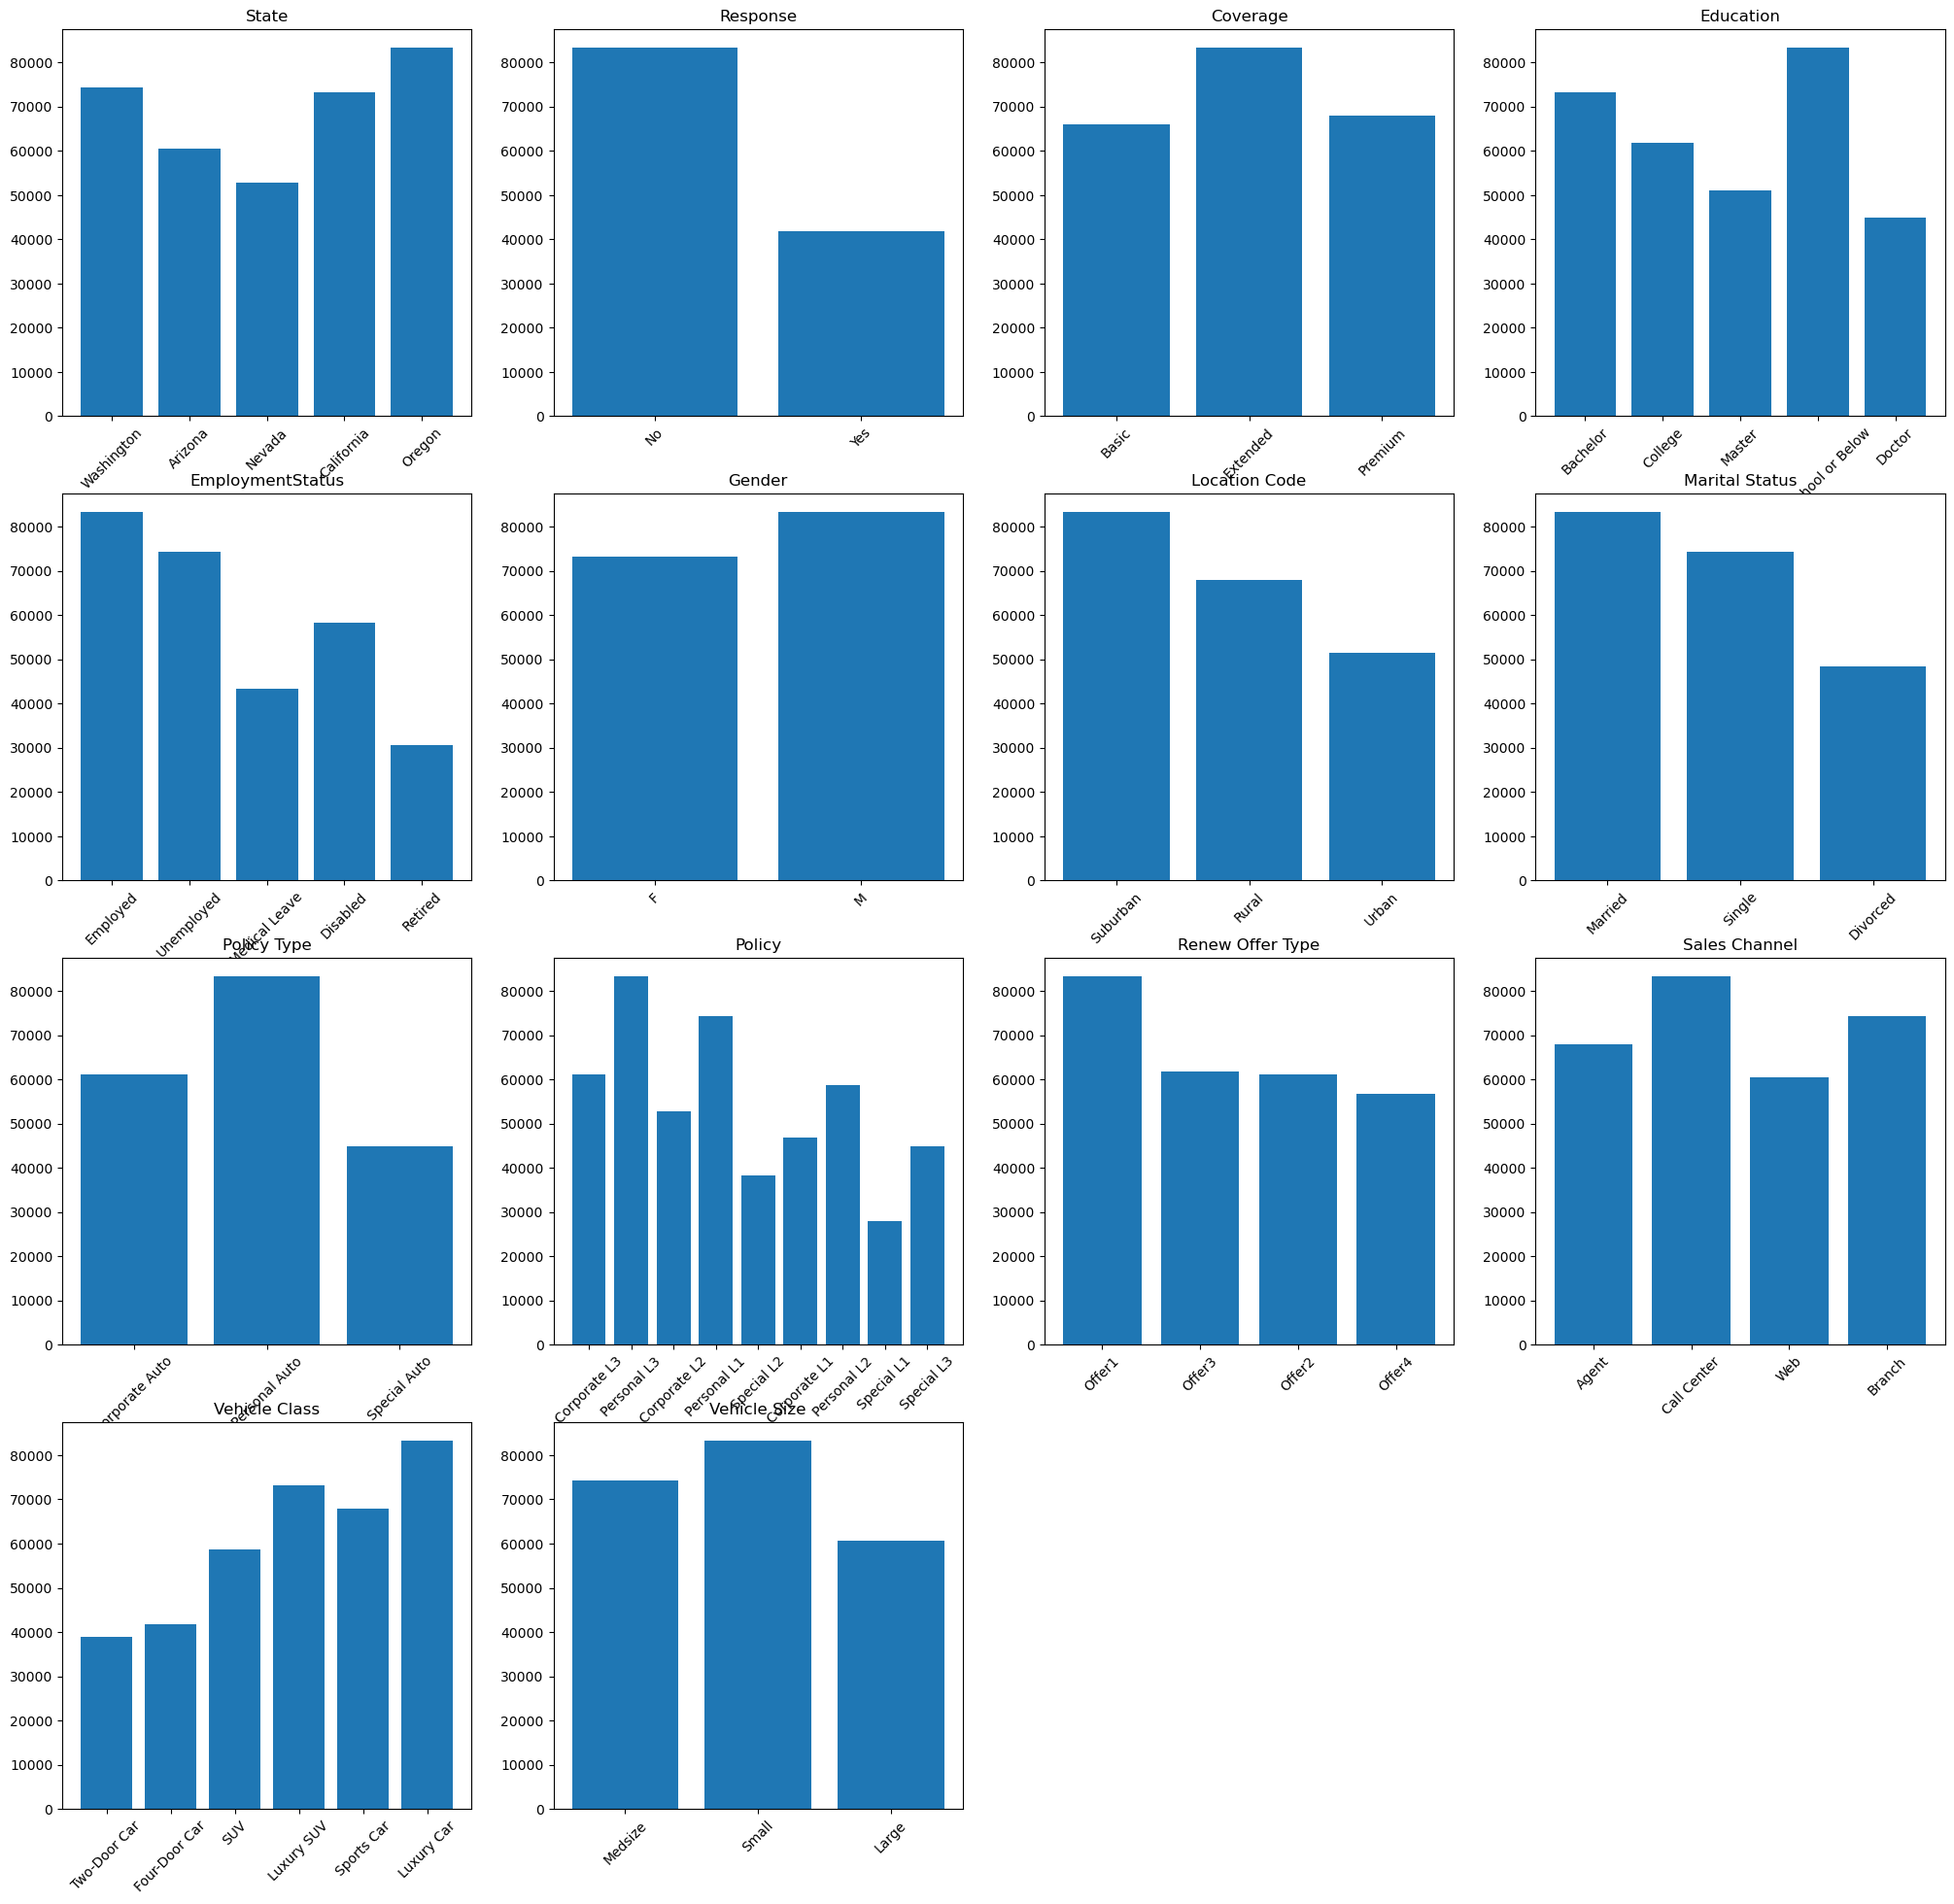

In [7]:
plt.figure(figsize=[25, 30])
plt.tight_layout()
for i, feature in enumerate(categorical_features):
    plt.subplot(5,4,i+1)
    plt.bar(df[feature], df['Customer Lifetime Value'])
    plt.xticks(rotation = 45)
    plt.title(feature)

### Вывод по категориальным признакам:

Визуально есть зависимость между этими признаками и таргетной переменной, оставим эти признаки в модели и оцифруем их с помощью LabelEncoder

In [8]:
import warnings
warnings.filterwarnings('ignore')
df_encoded = df[categorical_features]
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
for feature in categorical_features:
    df_encoded[feature] = labelencoder.fit_transform(df_encoded[feature])

Посмотрим на числовые признаки и построим графики зависимости с таргетом

In [9]:
df[numeric_features].describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


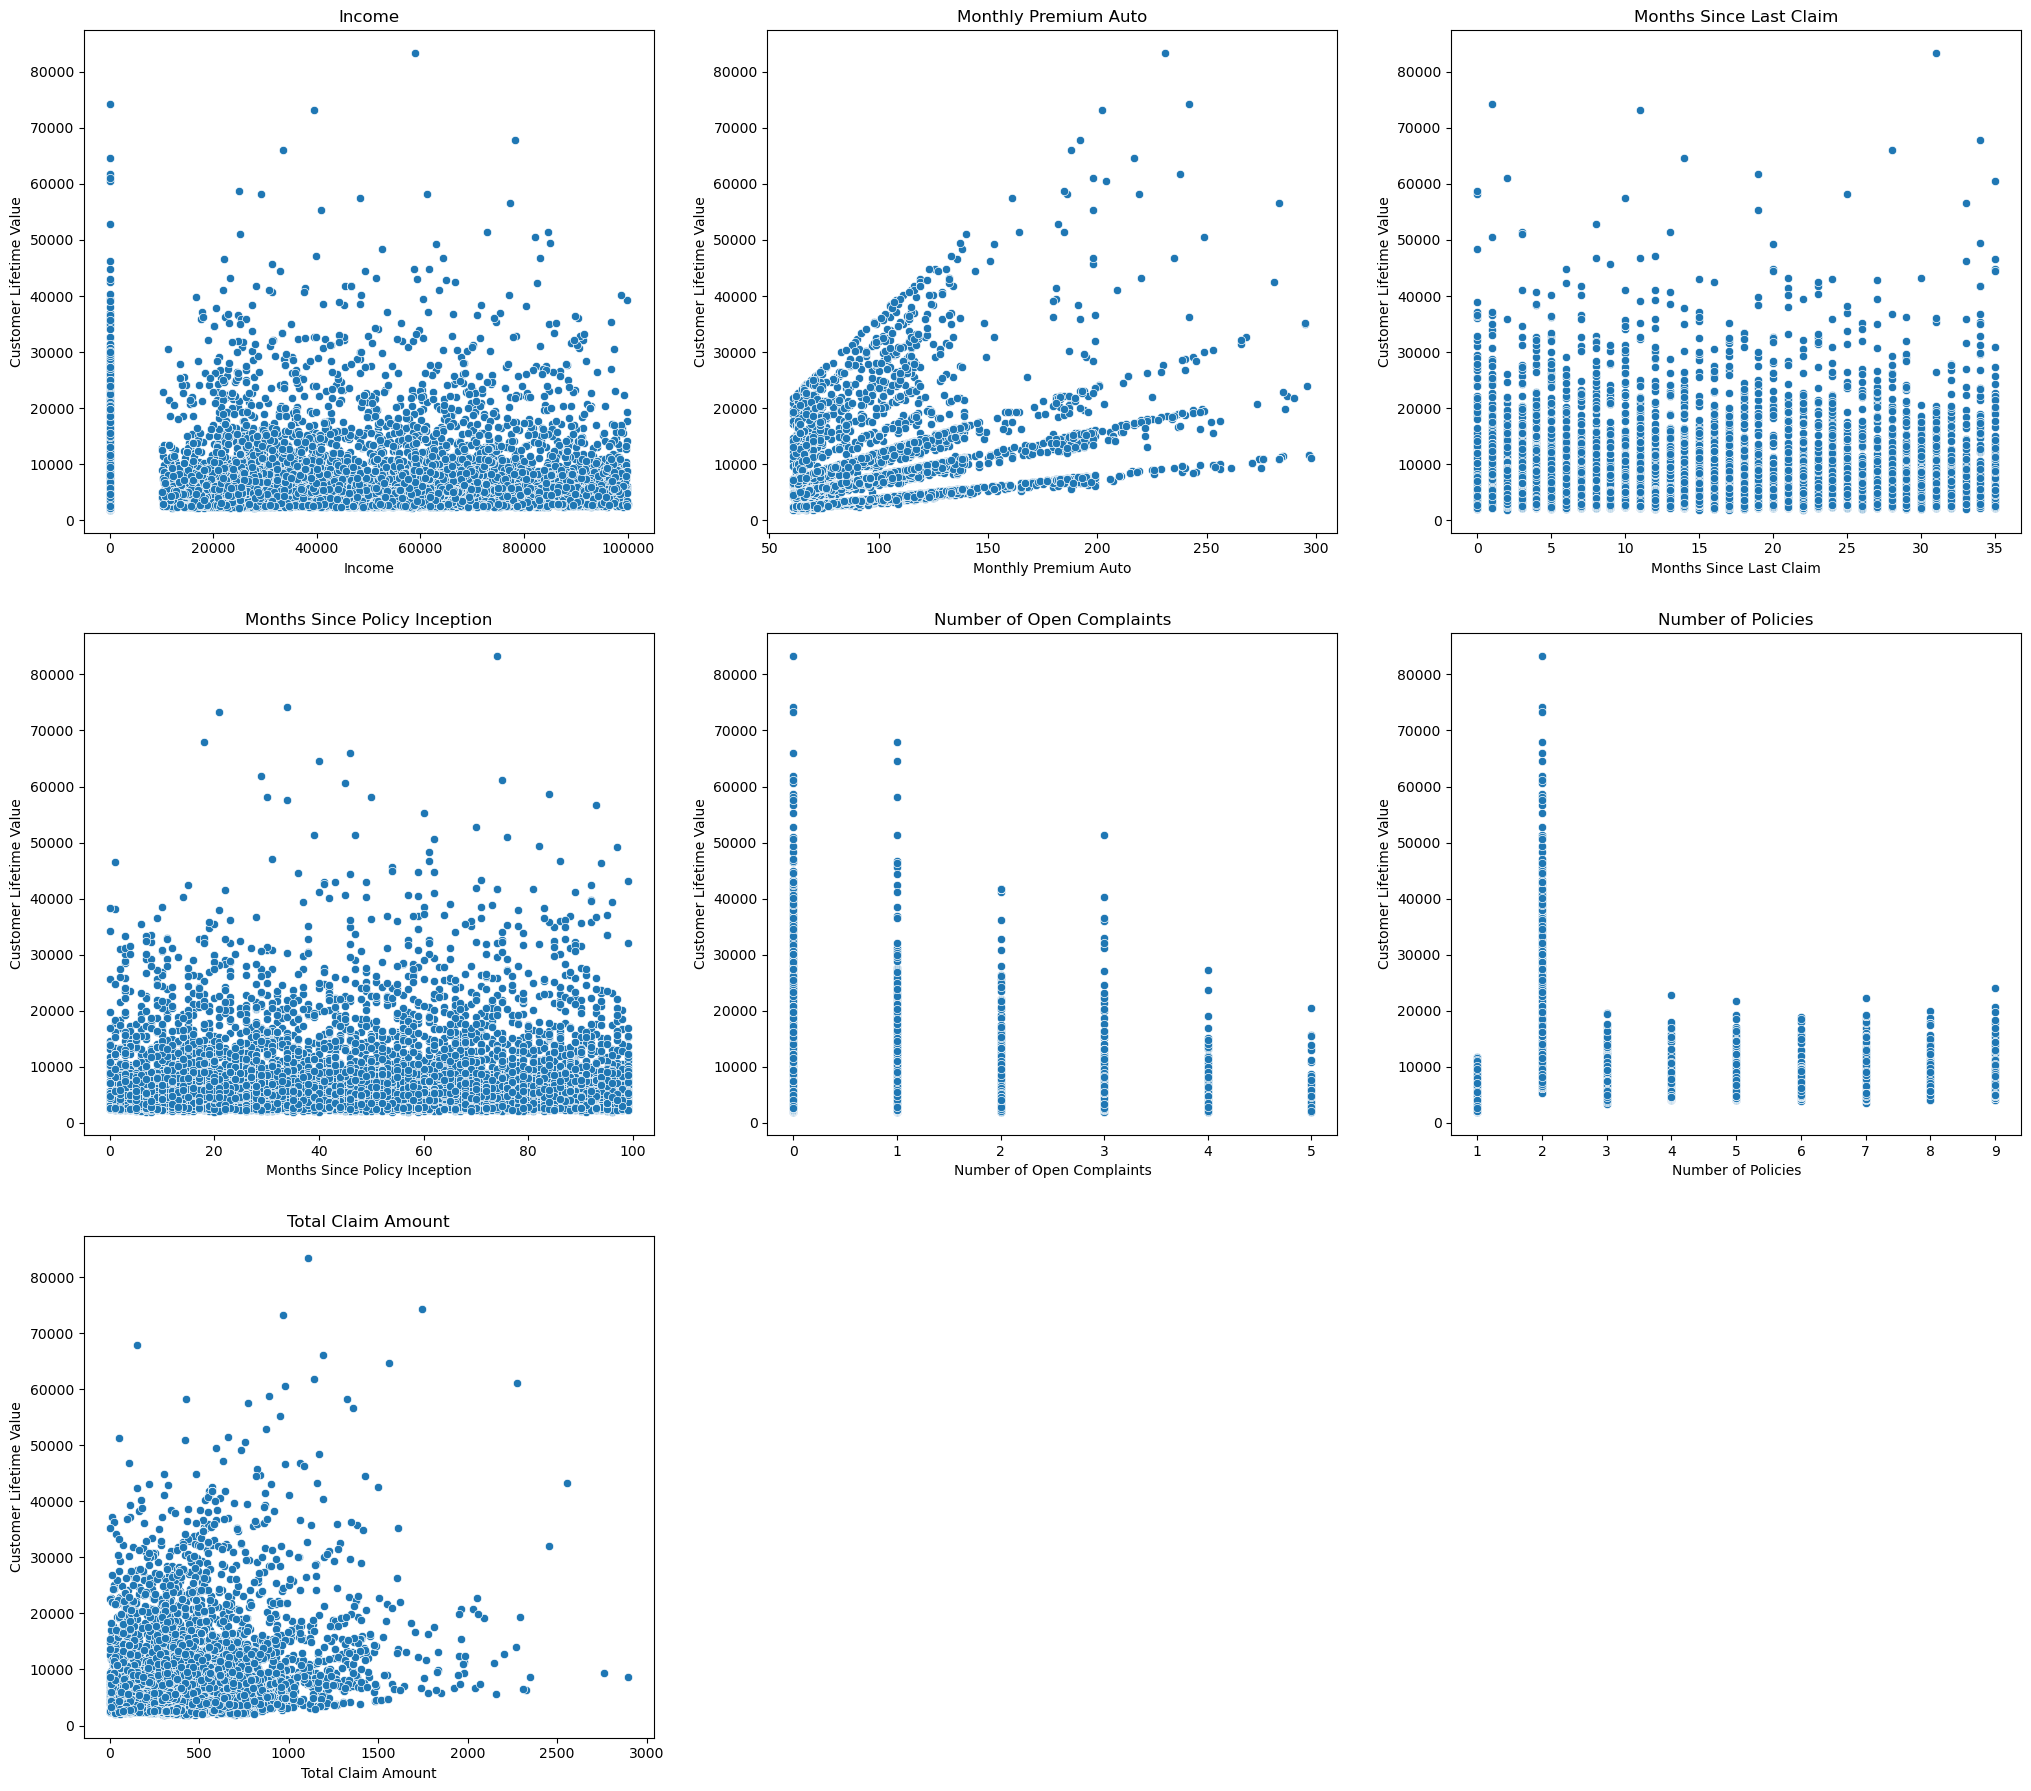

In [10]:
numeric_features_for_plot = ['Income','Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Total Claim Amount']

plt.figure(figsize=[25, 30])
plt.tight_layout()
for i, feature in enumerate(numeric_features_for_plot):
    plt.subplot(4,3,i+1)
    sns.scatterplot(y = df['Customer Lifetime Value'], x = df[feature])
    plt.title(feature)

Объединим числовые и оцифрованные категориальные данные и посмотрим на корреляцию между всеми признаками и тарегетом.

In [11]:
fin_df = pd.concat([df_encoded, df[numeric_features]], axis = 1)
fin_df

,State,Response,Coverage,Education,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,...,Vehicle Class,Vehicle Size,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
0,4,0,0,0,1,0,1,1,0,2,...,5,1,2763.519279,56274,69,32,5,0,1,384.811147
1,0,0,1,0,4,0,1,2,1,5,...,0,1,6979.535903,0,94,13,42,0,8,1131.464935
2,2,0,2,0,1,0,1,1,1,5,...,5,1,12887.431650,48767,108,18,38,0,2,566.472247
3,1,0,0,0,4,1,1,1,0,1,...,3,1,7645.861827,0,106,18,65,0,7,529.881344
4,4,0,0,0,1,1,0,2,1,3,...,0,1,2813.692575,43836,73,12,44,0,1,138.130879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,1,0,0,0,1,1,2,1,1,3,...,0,1,23405.987980,71941,73,18,89,0,2,198.234764
9130,1,1,1,1,1,0,1,0,0,2,...,0,1,3096.511217,21604,79,14,28,0,1,379.200000
9131,1,0,1,0,4,1,1,2,0,1,...,0,1,8163.890428,0,85,9,37,3,2,790.784983
9132,1,0,1,1,1,1,1,1,1,4,...,0,0,7524.442436,21941,96,34,3,0,3,691.200000


<AxesSubplot:>

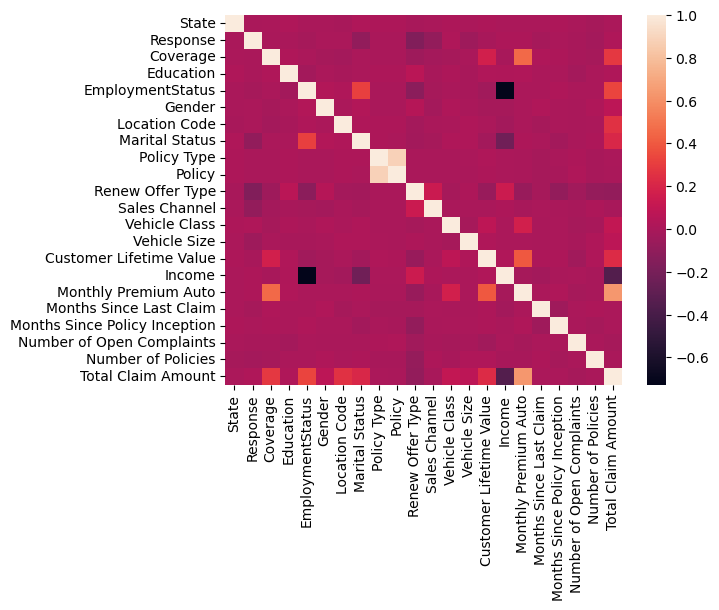

In [12]:
sns.heatmap(fin_df.corr())

Итак, есть несколько взаимозависимых признаков. Посмотрим, есть ли среди них больше 0,6. Удалим эти признаки из модели, так как они скорее всего дублируются похожими признаками.

In [13]:
cor_matrix = fin_df.corr().abs()
upper_triangle = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.60)]
to_drop

['Policy', 'Income', 'Total Claim Amount']

In [14]:
fin_df = fin_df.drop(to_drop, axis = 1)

Отделим таргет от признаков и разобъем весь массив данных на учебную и тестовую выборки.

In [15]:
y = fin_df['Customer Lifetime Value']
X = fin_df.drop('Customer Lifetime Value', axis = 1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Шаг 2. Регрессоры без настройки

Возьмем 4 регрессора без настройки гипрепараметров, обучим их на учебной выборке и протестируем на тестовой. Сравнив их основные метрики.

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor

names = ['GradientBoost', 'XGB', 'CatBoost', 'LightGMB']
regressors = [GradientBoostingRegressor(verbose=False), XGBRFRegressor(), CatBoostRegressor(verbose=False), LGBMRegressor()]

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import warnings
warnings.filterwarnings('ignore')

scores = pd.DataFrame()
for name, reg in zip(names, regressors):
    
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    new_row = {'Test':name, 'RMSE':round(np.sqrt(mean_squared_error(y_test, y_pred)),2),
               'MAE':round(mean_absolute_error(y_test, y_pred),2),
               'MAPE': round(mean_absolute_percentage_error(y_test, y_pred),4),
               'R2_score': round(r2_score(y_test, y_pred),4)
               }
    scores = scores.append(new_row, ignore_index=True)

scores = scores.set_index('Test')
scores.style.format('{:.2f}')

display(scores.sort_values(by = 'R2_score', ascending = False))

,RMSE,MAE,MAPE,R2_score
Test,,,,
LightGMB,3993.27,1572.88,0.1235,0.6906
CatBoost,3994.19,1702.42,0.1543,0.6904
XGB,4058.37,1667.71,0.1228,0.6804
GradientBoost,4120.22,1742.50,0.1393,0.6706


Обычно для оценки регрессии используют MSE - мера квадратичнорй суммы всех расстояний между предсказанными и истинными значениями. Чем выше ее значение, тем хуже модель. Для удобства интерпретации я вычислила квадратный корень из MSE, чтобы можно было сравнивать со средним значение тарегета. 

Ранжировать модели буду по r2, по которой LightGBM regressor является лучшей моделью. При этом - эта же модель является лучшей и по MSE.

In [18]:
fin_df['Customer Lifetime Value'].mean()

8004.9404749870755

## Шаг 3. Работа с гиперпараметрами и признаками

Попробуем улучшить качество модели, меняя гиперпараметры с помощью GridSearch. 

После получения луших параметров, насколько важны признаки в модели с использованием SelectPercentile для оценки качества модели при различных количествах признаков.

Анализ будем проводить по одной схеме и начнем c шага

### 3.1. Настройка CatBoost

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

catboost = CatBoostRegressor(verbose= False)
pipe = Pipeline([('scaler',scaler),('catboost', catboost)])

param_grid = {'catboost__learning_rate': [0.01, 0.1],
             'catboost__depth': [6, 10, 12],
             'catboost__l2_leaf_reg': [0.1, 0.5, 1]}

grid_cat = GridSearchCV(pipe, param_grid=param_grid, cv = 3, scoring = 'r2', verbose=False)
grid_cat.fit(X_train, y_train)

grid_cat.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('catboost', <catboost.core.CatBoostRegressor at 0x20e66d03730>)],
 'verbose': False,
 'scaler': StandardScaler(),
 'catboost': <catboost.core.CatBoostRegressor at 0x20e66d03730>,
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'catboost__learning_rate': 0.01,
 'catboost__depth': 6,
 'catboost__l2_leaf_reg': 0.1,
 'catboost__loss_function': 'RMSE',
 'catboost__verbose': False}

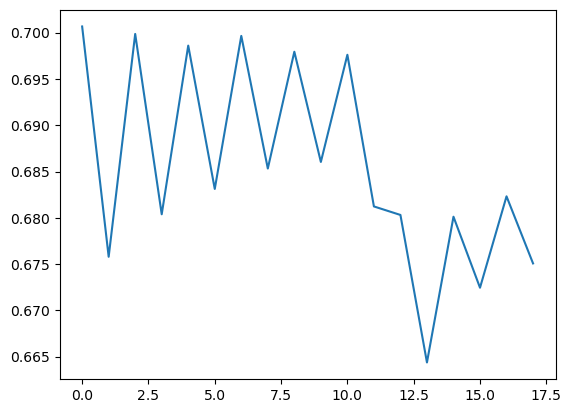

In [20]:
plt.plot(pd.DataFrame(grid_cat.cv_results_)['mean_test_score'])
plt.show()

### 3.2. Настройка XGB

In [21]:
xgb = XGBRFRegressor(verbose= False)
pipe = Pipeline([('scaler',scaler),('xgb', catboost)])

param_grid = { 'xgb__max_depth': [6,10,12],
               'xgb__n_estimators': [200,300,400],
               'xgb__learning_rate': [0.05, 0.1]}

grid_xgb = GridSearchCV(pipe, param_grid=param_grid, cv = 5, scoring = 'r2', verbose=False)
grid_xgb.fit(X_train, y_train)

grid_xgb.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('xgb', <catboost.core.CatBoostRegressor at 0x20e67220df0>)],
 'verbose': False,
 'scaler': StandardScaler(),
 'xgb': <catboost.core.CatBoostRegressor at 0x20e67220df0>,
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'xgb__learning_rate': 0.05,
 'xgb__loss_function': 'RMSE',
 'xgb__verbose': False,
 'xgb__max_depth': 6,
 'xgb__n_estimators': 300}

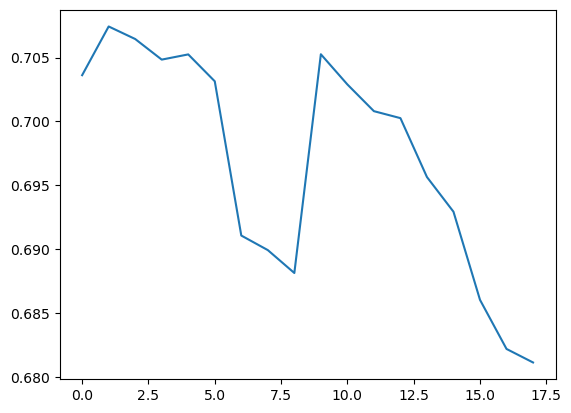

In [22]:
plt.plot(pd.DataFrame(grid_xgb.cv_results_)['mean_test_score'])
plt.show()

### 3.3. Настройка LightGMB

In [23]:
lgbm = LGBMRegressor()
pipe = Pipeline([('scaler',scaler),('lgbm', lgbm)])

param_grid = {'lgbm__num_leaves': [7, 31, 50],
              'lgbm__learning_rate': [0.1, 0.2, 0.01],
              'lgbm__max_depth': [-1, 7, 10],
              'lgbm__n_estimators': [100, 400, 600]}


grid_lgbm = GridSearchCV(pipe, param_grid=param_grid, cv = 3, scoring = 'r2', verbose=False)
grid_lgbm.fit(X_train, y_train)

grid_lgbm.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('lgbm', LGBMRegressor(learning_rate=0.01, n_estimators=400))],
 'verbose': False,
 'scaler': StandardScaler(),
 'lgbm': LGBMRegressor(learning_rate=0.01, n_estimators=400),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'lgbm__boosting_type': 'gbdt',
 'lgbm__class_weight': None,
 'lgbm__colsample_bytree': 1.0,
 'lgbm__importance_type': 'split',
 'lgbm__learning_rate': 0.01,
 'lgbm__max_depth': -1,
 'lgbm__min_child_samples': 20,
 'lgbm__min_child_weight': 0.001,
 'lgbm__min_split_gain': 0.0,
 'lgbm__n_estimators': 400,
 'lgbm__n_jobs': -1,
 'lgbm__num_leaves': 31,
 'lgbm__objective': None,
 'lgbm__random_state': None,
 'lgbm__reg_alpha': 0.0,
 'lgbm__reg_lambda': 0.0,
 'lgbm__silent': 'warn',
 'lgbm__subsample': 1.0,
 'lgbm__subsample_for_bin': 200000,
 'lgbm__subsample_freq': 0}

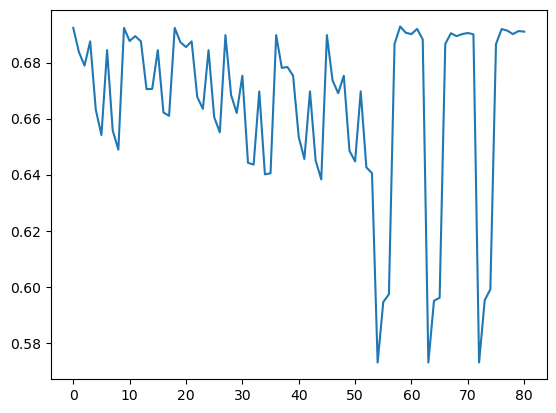

In [24]:
plt.plot(pd.DataFrame(grid_lgbm.cv_results_)['mean_test_score'])
plt.show()

### 3.3. Настройка GradientBoost

In [25]:
gb = GradientBoostingRegressor(verbose=False)
pipe = Pipeline([('scaler',scaler),('gb', gb)])

param_grid = {'gb__learning_rate': [0.1, 0.01],
              'gb__max_depth': [3, 5, 7],
              'gb__n_estimators': [50, 100, 200, 500]}


grid_gb = GridSearchCV(pipe, param_grid=param_grid, cv = 3, scoring = 'r2', verbose=False)
grid_gb.fit(X_train, y_train)

grid_gb.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('gb',
   GradientBoostingRegressor(max_depth=7, n_estimators=50, verbose=False))],
 'verbose': False,
 'scaler': StandardScaler(),
 'gb': GradientBoostingRegressor(max_depth=7, n_estimators=50, verbose=False),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'gb__alpha': 0.9,
 'gb__ccp_alpha': 0.0,
 'gb__criterion': 'friedman_mse',
 'gb__init': None,
 'gb__learning_rate': 0.1,
 'gb__loss': 'squared_error',
 'gb__max_depth': 7,
 'gb__max_features': None,
 'gb__max_leaf_nodes': None,
 'gb__min_impurity_decrease': 0.0,
 'gb__min_samples_leaf': 1,
 'gb__min_samples_split': 2,
 'gb__min_weight_fraction_leaf': 0.0,
 'gb__n_estimators': 50,
 'gb__n_iter_no_change': None,
 'gb__random_state': None,
 'gb__subsample': 1.0,
 'gb__tol': 0.0001,
 'gb__validation_fraction': 0.1,
 'gb__verbose': False,
 'gb__warm_start': False}

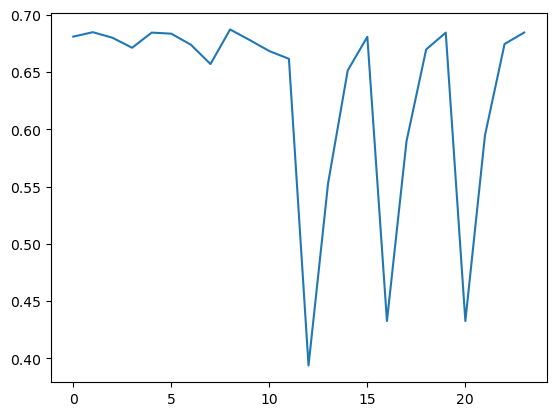

In [26]:
plt.plot(pd.DataFrame(grid_gb.cv_results_)['mean_test_score'])
plt.show()

## Тестирование отобранных регрессоров

Посмотрим, какой результат дадут настроенные модели на той же тестовой выборке. Сравним полученные результаты с работой тех же моделей "из коробки".

In [27]:
regressors = [grid_xgb, grid_cat, grid_lgbm, grid_gb ]
names = ['XGB', 'CatBoost', 'LightGMB', 'GradientBoost']

scores2 = pd.DataFrame()
for name, reg in zip(names, regressors):
    
    
    y_pred = reg.predict(X_test)
    new_row = {'Test':name, 'RMSE_2':round(np.sqrt(mean_squared_error(y_test, y_pred)),2),
               'MAE_2':round(mean_absolute_error(y_test, y_pred),2),
               'MAPE_2': round(mean_absolute_percentage_error(y_test, y_pred),4),
               'R2_score_2': round(r2_score(y_test, y_pred),4)
               }
    scores2 = scores2.append(new_row, ignore_index=True)

scores2 = scores2.set_index('Test')
scores.style.format('{:.2f}')
tot_scores = pd.merge(scores, scores2, on = 'Test')
tot_scores[['RMSE', 'RMSE_2', 'MAE', 'MAE_2', 'MAPE', 'MAPE_2','R2_score', 'R2_score_2']]

,RMSE,RMSE_2,MAE,MAE_2,MAPE,MAPE_2,R2_score,R2_score_2
Test,,,,,,,,
GradientBoost,4120.22,4048.25,1742.50,1563.71,0.1393,0.1152,0.6706,0.6820
XGB,4058.37,3947.86,1667.71,1632.52,0.1228,0.1294,0.6804,0.6976
CatBoost,3994.19,3969.54,1702.42,1623.24,0.1543,0.1246,0.6904,0.6942
LightGMB,3993.27,3995.13,1572.88,1578.45,0.1235,0.1256,0.6906,0.6903


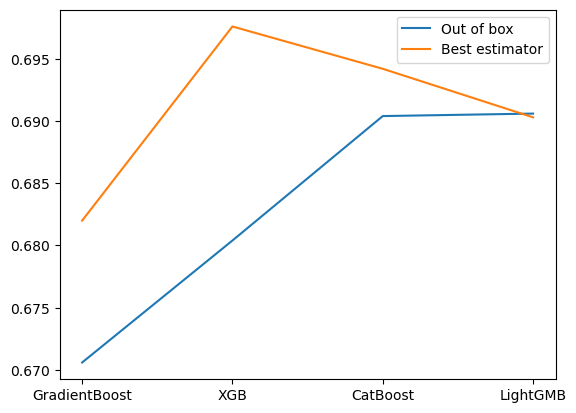

In [28]:
plt.plot(tot_scores['R2_score'], label = 'Out of box')
plt.plot(tot_scores['R2_score_2'], label = 'Best estimator')
plt.legend()

## Вывод:

После настройки ряда основных параметров метрики улучшились, но не очень значительно. По LightGBM вообще не удаось добиться изменений. Скорее всего, нужно больше работать с исходными данными и другими гиперпараметрами.